In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import tqdm
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchmetrics
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split


INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


Functions:


In [ ]:
#transforms.py
def get_transforms(img_size=(50,50)):
    """
    Create data augmentation pipelines for training and validation datasets.
    """
    train_transform = A.Compose([
        A.Resize(height=img_size[0], width=img_size[1]),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10, p=0.4),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(height=img_size[0], width=img_size[1]),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])

    return train_transform, val_transform
# dataloaders.py
class create_dataset(Dataset):
    """
    Custom dataset class for creating a PyTorch dataset from a DataFrame.
    """
    def __init__(self, df, trans=None):
        self.df = df
        self.trans = trans
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        row = self.df.iloc[i]
        file_path = row['file_path']
        label = row.get('label', None)

        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.trans:
            img = self.trans(image=img)['image']

        if label is None:
            return img
        else:
            return img, torch.tensor(label, dtype=torch.float32)

    
def create_data_loaders(df, batch_size=32, img_size=(50,50), val_split=0.2, labelled=True):
    train_transform, val_transform = get_transforms(img_size)

    if labelled:
        train_ds, val_ds = train_test_split(df, test_size=val_split, random_state=17, shuffle=True)   
        train_dataset = create_dataset(train_ds, trans=train_transform)
        val_dataset = create_dataset(val_ds, trans=val_transform)

        train_load = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
        val_load = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

        return train_load, val_load
    else:
        test_dataset = create_dataset(df, trans=val_transform)
        test_load = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

        return test_load
    
#model.py
class CNNmodel(nn.Module):
    def __init__(self, conv_filters=(32, 64, 128), input_channels=3, dense_units=256, dropout_p=0.3, num_classes=2, fc_dimension=128, img_size=(50,50)):
        super(CNNmodel, self).__init__()

        self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels, out_channels=conv_filters[0], kernel_size=3, stride=1, padding=1), #convolutional layer 1
        nn.BatchNorm2d(conv_filters[0]), #normalization layer 1
        nn.ReLU(), #activation function
        nn.MaxPool2d(kernel_size=2) #pooling layer
        )

        self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=conv_filters[0], out_channels=conv_filters[1], kernel_size=3, stride=1, padding=1), #convolutional layer 2
        nn.BatchNorm2d(conv_filters[1]), #normalization layer
        nn.ReLU(), #activation function
        nn.MaxPool2d(kernel_size=2) #pooling layer
        )

        self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=conv_filters[1], out_channels=conv_filters[2], kernel_size=3, stride=1, padding=1), #convolutional layer 3
        nn.BatchNorm2d(conv_filters[2]), #normalization layer
        nn.ReLU(), #activation function
        nn.MaxPool2d(kernel_size=2) #pooling layer
        )

        self.fc1 = nn.Linear(conv_filters[2] * 6 * 6, dense_units) #fully connected layer (* 6 * 6 depends on input image size basically is img_size//(2^number of pooling layers))
        self.fc2 = nn.Linear(dense_units, 1) #output layer

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)

        return logits
    
#train.py
def train_model(train_loader, val_loader, epochs=10, lr=0.001, device=None, checkpoint_path="E:/Coding_stuffs/Python/medical_images_checkpoint/checkpoint.pth"):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNmodel().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 
     

Linking images to labels

In [3]:
labels = pd.read_csv("../data/raw/histopathologic-cancer-detection/train_labels.csv")
labels['file_path'] = "../data/raw/histopathologic-cancer-detection/train/" + labels['id'] + ".tif"
pd.set_option('display.max_colwidth', None)
labels.head()


,id,label,file_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../data/raw/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../data/raw/histopathologic-cancer-detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,../data/raw/histopathologic-cancer-detection/train/755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../data/raw/histopathologic-cancer-detection/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../data/raw/histopathologic-cancer-detection/train/068aba587a4950175d04c680d38943fd488d6a9d.tif


Checking create_data_loaders works and images are read properly

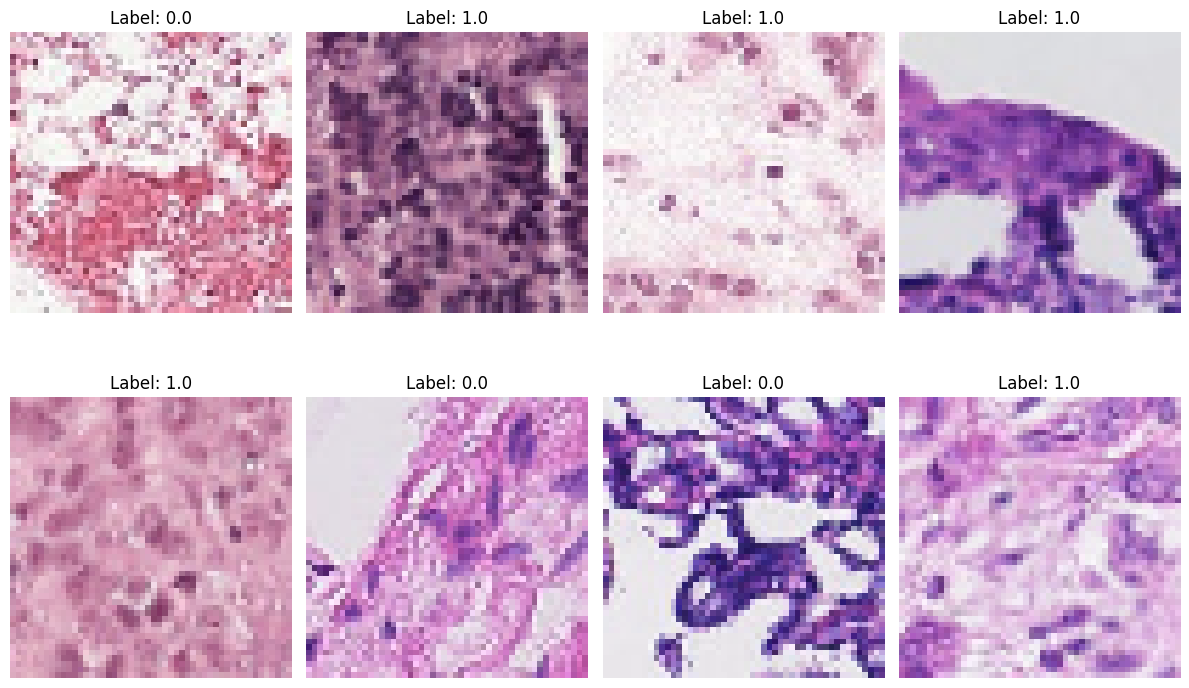

In [ ]:
train_loader, val_loader = create_data_loaders(labels, batch_size=16)
imgs, labels = next(iter(train_loader))
imgs = imgs.permute(0, 2, 3, 1).numpy()
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow((imgs[i] * 0.5 + 0.5))
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Creating test dataloader, creating training and validation data loaders.

In [ ]:
test_images = "../data/raw/histopathologic-cancer-detection/test/"
test_files = pd.DataFrame({'file_path': [test_images + f for f in os.listdir(test_images)]})

test_loader = create_data_loaders(test_files, batch_size=32, labelled=False)
train_loader, val_loader = create_data_loaders(labels, batch_size=32)